# The Plan Of Attack

Our task is to idenitfy the density of capuchin birrd calls inside an audio file (Forest recordings)

> Now first thing first the audio files are few minutes long but our train files (parsed_capuchin/not_capuchin .wav files) are hardly a few seconds long

> we will have to convert the audio file into segments of few seconds and make our model predict and sum these predictions to get the final count

**Now that thats done**

> We have .wav files, we will load these files and get their wavelengths 

> Now that we have the wavelengths, we will convert these into spectrograms (Images)

> we will create a CNN model

>Then feed these spectrograms to the the model and make predictions

>Next we will move towards the Forest recording files and segment them as we discussed earlier and perform all these previous steps on those files

# Lets Attack!!!

# Import the dependencies

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
import tensorflow as tf
import tensorflow_io as tfio

# Build a function to load the files and resample the wavelength of the audio

In [4]:
capuchin = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips','XC114131-1.wav')
not_capuchin = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips','Crickets-chirping-0.wav')

> Read the file

> Decode the wavelength of the file

> Convert the amplitude of audio from 44100Hz to 16000hz

In [5]:
def load_aud(filename):
    aud_file = tf.io.read_file(filename)
    
    wave,sample_rate = tf.audio.decode_wav(aud_file,desired_channels=1)
    
    wave = tf.squeeze(wave,axis=-1)
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)
    
    wave = tfio.audio.resample(wave, rate_in = sample_rate,rate_out = 16000)
    return wave

# Visualize the wavelengths

2022-10-12 05:14:47.507697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 05:14:47.607575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 05:14:47.608368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 05:14:47.610533: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

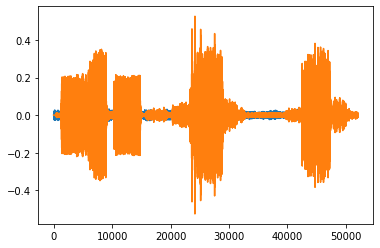

In [6]:
ywave = load_aud(capuchin)
nwave = load_aud(not_capuchin)
plt.plot(ywave)
plt.plot(nwave)
plt.show()

# Now lets create a tensorflow dataset


> Create paths to positive and negative data and add labels to these datasets

In [7]:
POS = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')
NEG = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

> Concatenate the two datasets to get a complete dataset

In [8]:
data= positives.concatenate(negatives)

In [9]:
len(data)

810

# Find the average length of a capuchin bird call

In [10]:
lengths = []
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_aud(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

In [11]:
print('Average length of the call:',tf.math.reduce_mean(lengths))
print('Min length of the call:',tf.math.reduce_min(lengths))
print('Max length of the call:',tf.math.reduce_max(lengths))

Average length of the call: tf.Tensor(54156, shape=(), dtype=int32)
Min length of the call: tf.Tensor(32000, shape=(), dtype=int32)
Max length of the call: tf.Tensor(80000, shape=(), dtype=int32)


> we will consider length to be 48000 that way we dont lose too much data and neither are we left with a bulky unnecessary data 

# Convert these audio files into spectrogram

In [12]:
def spectro(file_path,label):
    wave = load_aud(file_path)
    wave =  wave[:48000]
    zero_padding = tf.zeros([48000]-tf.shape(wave),dtype=tf.float32)
    wave = tf.concat([zero_padding,wave],0)
    spectrogram = tf.signal.stft(wave, frame_length=320 , frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label

# Test the Function and visualize how the spectrogram looks

**1. Capuchin birds call**

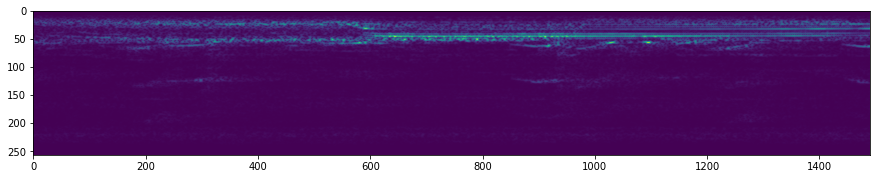

In [13]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

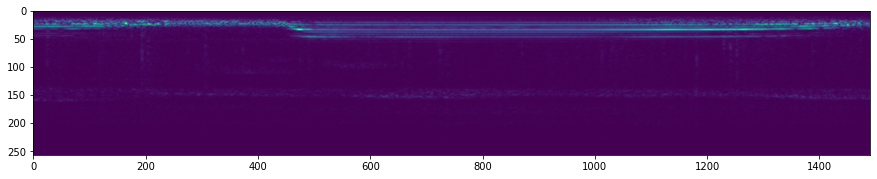

In [14]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

**2. Not a capuchin bird call**

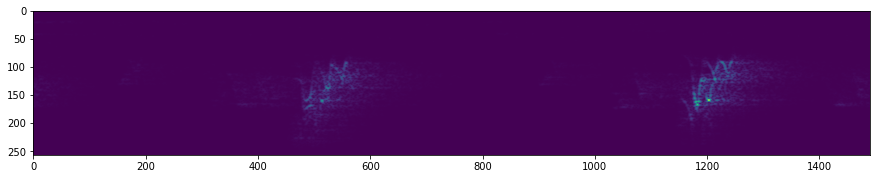

In [15]:
filepath,label = negatives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

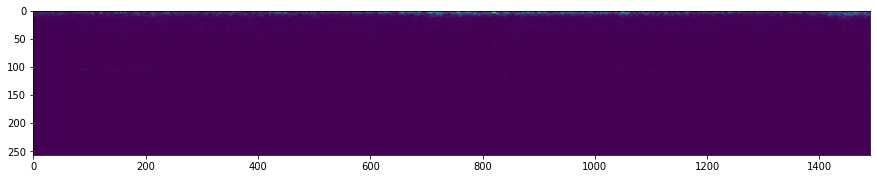

In [16]:
filepath,label = negatives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

> As we can see there is a very distinct pattern to the call of capuchin birds : it starts with a very strong lower note and then it is succeeded by a high pitch sound

# Now we will split the data into training and testing halves

> Before that lets create a tensorflow pipeline

In [18]:
data = data.map(spectro)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8) 

In [26]:
print(len(data))
print(51*0.7)

51
35.699999999999996


> Length of our data is 51 so if we do 70-30 split for train and test we get :-

In [22]:
train = data.take(36) 
test = data.skip(36).take(15)

In [27]:
samples, labels = train.as_numpy_iterator().next()
print(samples.shape)

2022-10-12 05:37:28.406688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 189 of 1000
2022-10-12 05:37:38.402948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 380 of 1000
2022-10-12 05:37:48.423535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 560 of 1000
2022-10-12 05:37:58.450780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 745 of 1000


(16, 1491, 257, 1)


2022-10-12 05:38:01.962531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


> (1491, 257, 1) will be our input shape to the model

# Lets Build Our Deep Learning Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.activations import relu,sigmoid

In [34]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile

In [35]:
model.compile(optimizer='Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1489, 255, 16)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 744, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 742, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 371, 62, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 368032)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               47108224  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# Fit the model

In [37]:
history = model.fit(train, validation_data=test,epochs=4) 

Epoch 1/4
36/36 [==============================] - 3s 70ms/step - loss: 1.3042 - recall_1: 0.7622 - precision_1: 0.5924 - val_loss: 0.1975 - val_recall_1: 0.8939 - val_precision_1: 0.9219
Epoch 2/4
36/36 [==============================] - 2s 64ms/step - loss: 0.0922 - recall_1: 0.9467 - precision_1: 0.9530 - val_loss: 0.0537 - val_recall_1: 0.9508 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 2s 60ms/step - loss: 0.0239 - recall_1: 0.9865 - precision_1: 0.9932 - val_loss: 0.0120 - val_recall_1: 0.9857 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 2s 59ms/step - loss: 0.0175 - recall_1: 0.9872 - precision_1: 1.0000 - val_loss: 0.0030 - val_recall_1: 1.0000 - val_precision_1: 1.0000


# Visualize the loss,recal and precision

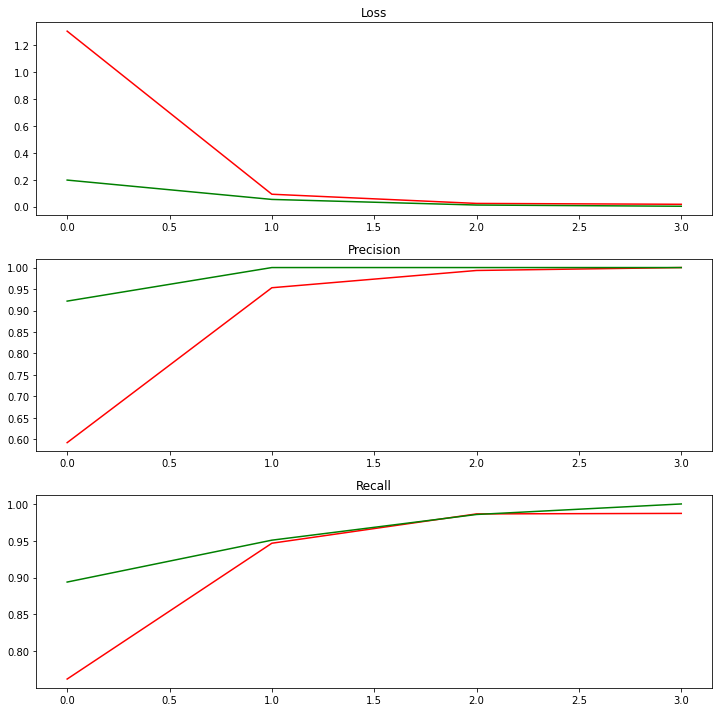

In [55]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=2.0)
plt.subplot(3,1,1)

plt.title('Loss')
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')

plt.subplot(3,1,2)
plt.title('Precision')
plt.plot(history.history['precision_1'],'r')
plt.plot(history.history['val_precision_1'],'g')

plt.subplot(3,1,3)
plt.title('Recall')

plt.plot(history.history['recall_1'],'r')
plt.plot(history.history['val_recall_1'],'g')


fig.tight_layout()


# Lets test and make some predictions

In [57]:
X_test,y_test = test.as_numpy_iterator().next()

y_hat = model.predict(X_test)

# Convert these predictions to Classes

In [58]:
y_hat = [1 if pred>0.5 else 0 for pred in y_hat]

> Lets check how many capuchin bird calls we predicted correctly

In [60]:
print(y_hat)
print(y_test.astype('int'))

[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
[0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0]


> Thats amazing we got every single one of the right

# Now we go to the Forest recordings

> so far we have worked with the other two folders and made our model now its the main part of our project

> This audio is in mp3 so lets make a function that will parse throught these and convert these mp3 files into wavelengths

In [65]:
def load_mp3(filename):
    aud = tfio.audio.AudioIOTensor(filename)
    # Convert these to tensor and combine channels 
    tensor = aud.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 

    sample_rate = aud.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

> Lets load one file

In [62]:
mp3 = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3(mp3)

In [68]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

# Lets Build A Function to Convert Clips into Spectrograms

In [69]:
def spectro_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

# Convert These Clips into Windows and Make Predictions

In [70]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(spectro_mp3)
audio_slices = audio_slices.batch(64)

> After going through that audio file i found out there are 5 calls. lets check if we can predict them correctly

In [75]:
y_hat = model.predict(audio_slices)
y_hat = [1 if prediction > 0.99 else 0 for prediction in y_hat]

> here we took prediction > 0.99 as we want only the most confident predictions to be labeled as 1

In [77]:
tf.math.reduce_sum(y_hat).numpy()

6

> it says 6 lets check why

In [78]:
y_hat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

> As we can see the two consecutive calls were counted separately but they are the same call 

In [80]:
from itertools import groupby

y_hat = [i for i,group in groupby(y_hat)]
calls = tf.math.reduce_sum(y_hat).numpy()
print(calls)

5


> Perfect we got a very accurate prediction

# Lets make predictions for the entire set of recordings

In [81]:
results = {}
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
    filepath = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing','Forest Recordings', file)
    
    wav = load_mp3(filepath)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(spectro_mp3)
    audio_slices = audio_slices.batch(64)
    
    y_hat = model.predict(audio_slices)
    
    results[file] = y_hat

# Convert these predictions into classes

In [83]:
class_predictions = {}
for file, logits in results.items():
    class_predictions[file] = [1 if prediction > 0.99 else 0 for prediction in logits]


In [84]:
postprocessed = {}
for file, scores in class_predictions.items():
    postprocessed[file] = tf.math.reduce_sum([i for i, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 1,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 5,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 3,
 'recording_17.mp3': 3,
 'recording_65.mp3': 4,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 3,
 'recording_64.mp3': 2,
 'recording_39.mp3': 5,
 'recording_04.mp3': 4,
 'recording_28.mp3': 15,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 1,
 'recording_59.mp3': 12,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 14,
 'recording_86.mp3': 12,
 'recording_47.mp3': 13,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 1,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recordin

# Thats That! We Succesfully Built A Model That Can Identify The Density Of The Capuchin Bird Calls!